In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices5.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
0,2023-04-13 12:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30212.40
1,2023-04-13 12:11:00,30212.40,NaN,NaN,NaN,NaN,NaN,NaN,30213.78
2,2023-04-13 12:12:00,30213.78,NaN,NaN,NaN,NaN,NaN,NaN,30218.90
3,2023-04-13 12:13:00,30218.90,NaN,NaN,NaN,NaN,NaN,NaN,30222.68
4,2023-04-13 12:14:00,30222.68,NaN,NaN,NaN,NaN,NaN,NaN,30206.54
...,...,...,...,...,...,...,...,...,...
1996,2023-04-14 21:26:00,30478.01,30223.61,30223.7424,30243.7114,30473.926030,30469.108962,30477.497380,30490.99
1997,2023-04-14 21:27:00,30490.99,30223.61,30223.7424,30243.7114,30478.412022,30470.859811,30477.531890,30491.87
1998,2023-04-14 21:28:00,30491.87,30223.61,30223.7424,30243.7114,30483.124017,30472.890595,30477.743263,30497.26
1999,2023-04-14 21:29:00,30497.26,30223.61,30223.7424,30243.7114,30487.228013,30474.940549,30477.832674,30499.54


## Dataset Summary

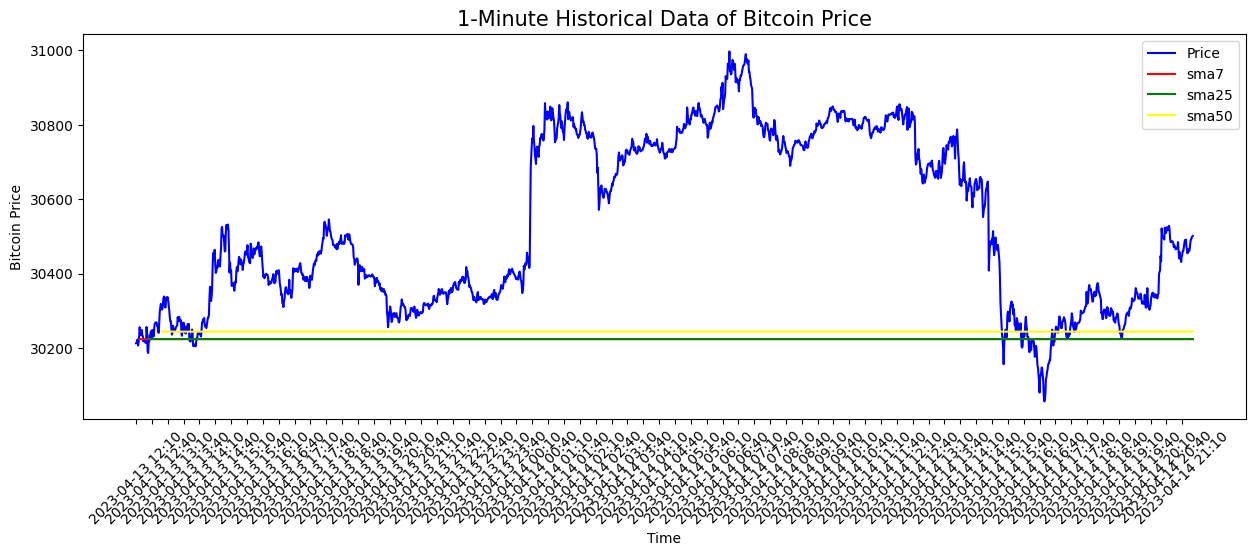

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.plot(df_chart.index, df_chart['sma7'], color='red', label='sma7')
plt.plot(df_chart.index, df_chart['sma25'], color='green', label='sma25')
plt.plot(df_chart.index, df_chart['sma50'], color='yellow', label='sma50')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

In [ ]:
#drop NAN rows
df = df.drop(df.index[:50])

feature_df = df.iloc[:,1:6]

In [ ]:
feature_df

In [ ]:
#Feature Scaling
scalar = StandardScaler()
df_ft = scalar.fit_transform(feature_df.values)
df_ft = pd.DataFrame(columns=feature_df. columns,
                    data=df_ft,
                    index=feature_df.index)

In [ ]:
df_ft

In [ ]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append (data[i:i + n_steps, : - 1])
        y.append(data[i + n_steps - 1, - 1])
    return np.array(X), np.array(y)

In [ ]:
X1, y1 = lstm_split(df_ft.values, n_steps=50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, y_test.shape)

## Sequential model

In [ ]:
model = Sequential ()
model. add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 50, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## Summary

In [ ]:
model.summary()

## Train

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=1)

In [ ]:
# model.save('model_004.h5')
# loaded_model = keras.models.load_model('model_004.h5')

## Evaluate

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, average_error_rate, fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

In [ ]:
# Define y_test_index with row labels
y_test_index = range(len(y_test))

# Convert numpy arrays to pandas series
y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

# Plot scatter plot
plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
